In [42]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
from PIL import Image 
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import os


USE_CUDA = True

In [43]:
def noise_image(img: np.ndarray, scale: float = 1.0) -> np.ndarray:
    """
    Noises an image with gaussian
    """
    noise = np.random.normal(loc=0, scale=scale, size=img.shape)
    return img + noise

Creation of data

In [44]:
class ImageSet(Dataset):
    def __init__(self, root_dir_input: str, root_dir_target: str, transform=None):
        super().__init__()

        self.root_dir_input = root_dir_input  # Input images
        self.root_dir_target = root_dir_target  # Target images (labels)
        self.image_names = sorted(os.listdir(root_dir_input))  # Ensure matching order

        self.transform = transform
        
    def __getitem__(self, idx):
        
        img_name = self.image_names[idx]
        img_input_path = os.path.join(self.root_dir_input, img_name)
        img_target_path = os.path.join(
            self.root_dir_target, img_name
        )  # Assume same filename


        img_input = Image.open(img_input_path).convert("RGB")
        img_target = Image.open(img_target_path).convert("RGB")

        if self.transform:
            img_input = self.transform(img_input)
            img_target = self.transform(img_target)


        return img_input, img_target  # Image as input, another image as label

    def __len__(self):
        return len(self.image_names)


folder = "Images/Denoising/train"


In [45]:

# for file in os.listdir(folder):
#     img = plt.imread(os.path.join(folder, "target", file), format="jpg")
#     img = noise_image(img, 10)
#     plt.imsave(
#         fname="/".join((folder, "input", file)),
#         arr=img.astype(np.uint8),
#     )

In [46]:
img_set = ImageSet(
    "Images/Denoising/train/input",
    "Images/Denoising/train/target",
    transform=torchvision.transforms.ToTensor(),
)
img_loader = DataLoader(img_set, batch_size=1)

Creation of

In [47]:
import torch.nn.functional as F
from torchvision.transforms.functional import crop


class UNet(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(UNet, self).__init__()

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.layer0 = self.__def_layer(in_channels, 64)
        self.layer1 = self.__def_layer(64, 128)
        self.layer2 = self.__def_layer(128, 256)
        self.layer3 = self.__def_layer(256, 512)
        self.layer4 = self.__def_layer(512, 1024)

        # Upstream layers
        self.upconv0 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.layer5 = self.__def_layer(1024, 512)

        self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.layer6 = self.__def_layer(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.layer7 = self.__def_layer(256, 128)

        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.layer8 = self.__def_layer(128, 64)

        self.final_layer = nn.Conv2d(64, out_channels, kernel_size=1, padding=1)

    def forward(self, x):
        x0 = self.layer0(x)
        x1 = self.layer1(self.max_pool(x0))
        x2 = self.layer2(self.max_pool(x1))
        x3 = self.layer3(self.max_pool(x2))
        x4 = self.layer4(self.max_pool(x3))

        x = self.upconv0(x4)
        x = self.__crop_cat(x3, x)
        x = self.layer5(x)

        x = self.upconv1(x)
        x = self.__crop_cat(x2, x)
        x = self.layer6(x)

        x = self.upconv2(x)
        x = self.__crop_cat(x1, x)
        x = self.layer7(x)

        x = self.upconv3(x)
        x = self.__crop_cat(x0, x)
        x = self.layer8(x)

        return self.final_layer(x)

    def __def_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def __crop_cat(self, x1, x2):
        """
        Crop x1 to match x2's spatial dimensions and concatenate along the channel
        dimension.
        """
        x1 = torchvision.transforms.functional.center_crop(
            x1, [x2.shape[2], x2.shape[3]]
        )

        return torch.cat([x1, x2], dim=1)

In [48]:
train = False


unet = UNet(3, 3)
optimizer = torch.optim.SGD(unet.parameters())

for i in range(10):
    for logit, target in img_loader:
        optimizer.zero_grad()
        out = unet(logit)

        # print(out.shape, target.shape, end="\n\r")
        loss = nn.functional.cross_entropy(out[:, :, :-1, :-1], target)
        loss.backward()
        optimizer.step()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42279613..0.2713011].


torch.Size([3, 482, 322])
Image saved as my-upscaled-image.jpg
[[[[-0.01064953 -0.01064953 -0.01064953 ... -0.01064953 -0.01064953
    -0.01064953]
   [-0.01064953 -0.01184576 -0.01597992 ... -0.01532839 -0.01858717
    -0.01064953]
   [-0.01064953 -0.00970544 -0.0147078  ... -0.01383698 -0.01608433
    -0.01064953]
   ...
   [-0.01064953 -0.01053311 -0.01405805 ... -0.01048051 -0.01201912
    -0.01064953]
   [-0.01064953 -0.01280802 -0.0132504  ... -0.01393396 -0.012367
    -0.01064953]
   [-0.01064953 -0.01064953 -0.01064953 ... -0.01064953 -0.01064953
    -0.01064953]]

  [[ 0.04178787  0.04178787  0.04178787 ...  0.04178787  0.04178787
     0.04178787]
   [ 0.04178787  0.04573581  0.0494739  ...  0.04322091  0.04325229
     0.04178787]
   [ 0.04178787  0.05093682  0.04824992 ...  0.04552043  0.0428781
     0.04178787]
   ...
   [ 0.04178787  0.04603874  0.04684229 ...  0.04448825  0.04452822
     0.04178787]
   [ 0.04178787  0.04267303  0.04337663 ...  0.04186957  0.04358199
     0

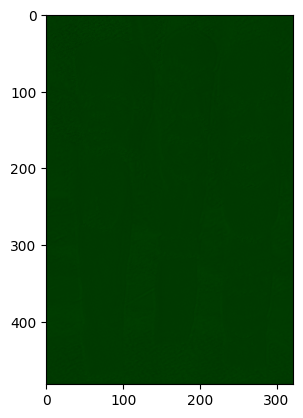

In [65]:
# img, target = img_loader.dataset[0]
import torchvision.transforms as transforms
import torch
import torchvision.transforms as transforms
from PIL import Image

def tensor_to_jpg(tensor: torch.Tensor, filename: str):
    """
    Converts a PyTorch tensor with arbitrary values to a normalized image and saves it as a .jpg file.
    
    Args:
        tensor (torch.Tensor): Input tensor with shape (C, H, W) and arbitrary values.
        filename (str): Name of the output .jpg file.
    """
    # Normalize tensor to [0,1] using min-max scaling
    min_val = tensor.min()
    max_val = tensor.max()
    tensor = (tensor - min_val) / (max_val - min_val)
    
    # Convert to PIL Image (expects tensor in range [0,1])
    to_pil = transforms.ToPILImage()
    image = to_pil(tensor)
    
    # Save as .jpg
    image.save(filename, format='JPEG')
    print(f"Image saved as {filename}")


for logit, target in img_loader:

    out: torch.Tensor = unet(logit)
    print(out[0].shape)

    tensor_to_jpg(target[0], 'my-upscaled-image.jpg')
    # s = s.detach().numpy()
    out = out.detach().numpy()
    logit = logit.detach().numpy()

    logit = np.permute_dims(logit[0], (1, 2, 0))

    print(out)
    out = np.permute_dims(out[0], (1, 2, 0))
    s = np.permute_dims(s, (1, 2, 0))
    plt.imshow(s)
    plt.show()
    break

# print(img.shape)
# out = unet.forward(img)

# img: np.ndarray = img.numpy()
# img = np.permute_dims(img, (1,2,0))

# # out: np.ndarray = out.numpy()
# # out = np.permute_dims(out, (1,2,0))

# target: np.ndarray = target.numpy()
# target = np.permute_dims(target, (1,2,0))

# # Create a figure with 1 row, 2 columns
# fig, axes = plt.subplots(1, 3, figsize=(10, 5))

# # Show input image
# axes[0].imshow(img)
# axes[0].set_title("Input Image")
# axes[0].axis("off")  # Hide axes for better visualization

# # Show target image
# axes[1].imshow(target)
# axes[1].set_title("Target Image")
# axes[1].axis("off")

# Show target image
# axes[2].imshow(out)
# axes[2].set_title("Output Image")
# axes[2].axis("off")
# Show the images
# plt.show()